Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.
As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up (with your own code).

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
import math

# Set the randomizer seed so results are the same each time.
np.random.seed(0)


Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000L, 784L)
label shape: (70000L,)


*Note: I used mini training data set for all of the problems except P5 and P6, since P6 explicitly mentioned the "training data" and I needed to use the same set of data for P5 for comparison of results with P6.  I kept all other problems to use the mini training data set since it would take an extremely long time to run on my laptop otherwise.

In [3]:
# Global variables 

digit_matrix_dim = 28

(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

•	plt.rc() for setting the colormap, for example to black and white

•	plt.subplot() for creating subplots

•	plt.imshow() for rendering a matrix

•	np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

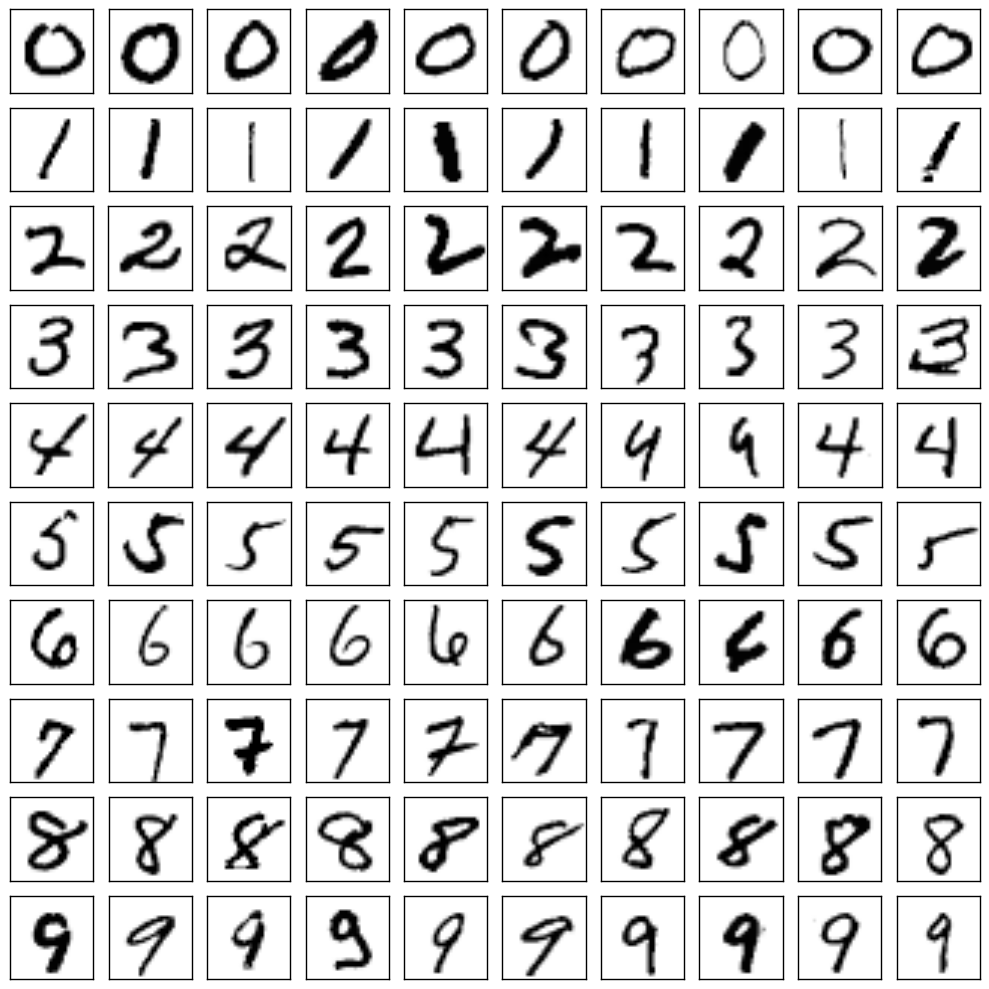

In [4]:
# Description : Function for P1
# Parameters  : Number of examples to display for each digit
# num_examples:
def P1(num_examples = 10):

### STUDENT START ###
    
    # Set dimensions of the grid of subplots
    grid, rows = plt.subplots(nrows = 10, 
                              ncols = num_examples,
                              figsize = (num_examples, 10))

    # Remove ticks and labels of the 10 x num_examples grid
    for ax in grid.axes:
        ax.set_xticks([])
        ax.set_yticks([])

    # Iterate each row of the 10 x num_examples grid, which correspond
    # to the ten digits in order
    for i, row in enumerate(rows):
        # Get the indices of the training data that contain the 
        # image of the digit corresponding to the current row
        train_indices_by_label = [k for k, label in enumerate(train_labels) if label == i]
        for j, cell in enumerate(row):
            # Reshape the 1D feature vector for a single digit into 
            # a 2D matrix for rendering
            digit_matrix = np.reshape(train_data[train_indices_by_label[j]], (digit_matrix_dim, digit_matrix_dim))
            # Show the digit in black and white color map
            cell.imshow(digit_matrix, cmap='Greys')

    plt.tight_layout()

### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

•	KNeighborsClassifier() for fitting and predicting

•	classification_report() for producing precision, recall, F1 results

In [5]:
# global list to store the predicted labels for 1-NN
pred_labels_k1 = []

# Description: Calculate the prediction accuracy based on results of a machine 
#              learning model
# Parameters : 
# dev_labels : The actual (development) labels to be predicted
# pred_labels: The predicted labels outpur by a ML model
def calc_accuracy(dev_labels, pred_labels):
    
    pred_accuracy = dev_labels == pred_labels    
    return (len(pred_accuracy[pred_accuracy == True]) * 1.0) / len(dev_labels) 

# Description : Predict digits (labels) on a development data set using a 
#               K-Nearest-Neighbors model (for single k value)
# Parameters  : 
# train_data  : Training data set
# train_labels: Labels (digits) of the training data set
# dev_data    : Development data set 
# dev_labels  : Labels (digits) of the development data set
# k           : Value of k of the KNeighborsClassifier being deployed
def predict_digits_kNN_single_k(train_data, train_labels, dev_data, dev_labels, k):
    
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_data, train_labels) 
    
    pred_labels = neigh.predict(dev_data)    
        
    if k == 1:
        pred_labels_k1.extend(pred_labels)
            
    return pred_labels

# Description : Call predict_digits_kNN_single_k to predict digits (labels) 
#               on a development data and then calculate accuracy of the model 
#               by calling calc_accuracy
# Parameters  : 
# train_data  : Training data set
# train_labels: Labels (digits) of the training data set
# dev_data    : Development data set 
# dev_labels  : Labels (digits) of the development data set
# k           : Value of k of the KNeighborsClassifier being deployed
def predict_digits_kNN_accuracy_single_k(train_data, train_labels, dev_data, dev_labels, k):
    
    pred_labels = predict_digits_kNN_single_k(train_data, train_labels, dev_data, dev_labels, k)
    return calc_accuracy(dev_labels, pred_labels)

# Description : Predict digits (labels) on a development data set using a 
#               K-Nearest-Neighbors model and trying various values of k
# Parameters  :
# train_data  : Training data set
# train_labels: Labels (digits) of the training data set
# dev_data    : Development data set 
# dev_labels  : Labels (digits) of the development data set
# k_values    : List of k values to try for the KNeighborsClassifier
def predict_digits_kNN(train_data, train_labels, dev_data, dev_labels, k_values):
    
    results = [None] * len(k_values)
    
    for i in range(len(k_values)):
        results[i] = predict_digits_kNN_accuracy_single_k(train_data, train_labels, dev_data, dev_labels, k_values[i])
        print 'Accuracy Percentage for k = %d: %f' % (k_values[i], results[i])
    return results

# Description: Function for P2
# Parameters :
# k_values   : List of k values to try for the KNeighborsClassifier
def P2(k_values):

### STUDENT START ###

    predict_digits_kNN(mini_train_data, mini_train_labels, dev_data, dev_labels, k_values) 
    if len(pred_labels_k1) > 0:
        print ''
        print(classification_report(dev_labels, pred_labels_k1, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])) 
    
### STUDENT END ###
         
k_values = [1, 3, 5, 7, 9]
P2(k_values)

Accuracy Percentage for k = 1: 0.888000
Accuracy Percentage for k = 3: 0.878000
Accuracy Percentage for k = 5: 0.869000
Accuracy Percentage for k = 7: 0.865000
Accuracy Percentage for k = 9: 0.863000

             precision    recall  f1-score   support

          0       0.91      0.98      0.94        99
          1       0.89      1.00      0.94       105
          2       0.99      0.79      0.88       102
          3       0.77      0.87      0.82        86
          4       0.89      0.82      0.85       104
          5       0.93      0.84      0.88        91
          6       0.94      0.96      0.95        98
          7       0.89      0.92      0.90       113
          8       0.94      0.88      0.91        96
          9       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000



ANSWER: The digit 9 seems to be the most difficult digit since it had the lowest f1-score.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

•	time.time() gives a wall clock value you can use for timing operations

In [6]:
# Description: Function for P3
# Parameters :
# train_sizes: List of training data sizes to try
# accuracies : Prediction accuracies corresponding to the list of
#              training data sizes
def P3(train_sizes, accuracies):
    
### STUDENT START ###

    # Create a new temp list
    temp_accuracies = [None] * len(train_sizes)
    # Set base time
    t0 = time.time()

    for i in range(len(train_sizes)):
        # Create lists with subset of training data according to the passed 
        # in training data sizes
        temp_train_data, temp_train_labels = train_data[:train_sizes[i]], Y[:train_sizes[i]]
        # Predict labels for the dev data set and calculate accuracy
        temp_accuracies[i] = predict_digits_kNN_accuracy_single_k(temp_train_data, temp_train_labels, dev_data, dev_labels, 1)
        # Get current time
        ti = time.time()
   
        print "Training data size = %d:" % train_sizes[i]
        # Calculate and display elapsed time
        print "Time needed = %3.2f" % (ti - t0)
        # Reset base time for next elapsed time calculation
        t0 = ti
        # Display accuracy for current training data size
        print "Accuracy = %3.2f\n" % temp_accuracies[i]
        
    # Merge contents of temp_accuracies into the passed in empty list 
    # accuracies to "return" the prediction accuracy results to the caller
    accuracies.extend(temp_accuracies)

### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []

P3(train_sizes, accuracies)
print accuracies

Training data size = 100:
Time needed = 0.19
Accuracy = 0.72

Training data size = 200:
Time needed = 0.37
Accuracy = 0.79

Training data size = 400:
Time needed = 0.72
Accuracy = 0.84

Training data size = 800:
Time needed = 1.50
Accuracy = 0.88

Training data size = 1600:
Time needed = 3.14
Accuracy = 0.90

Training data size = 3200:
Time needed = 6.42
Accuracy = 0.93

Training data size = 6400:
Time needed = 13.20
Accuracy = 0.94

Training data size = 12800:
Time needed = 28.40
Accuracy = 0.96

Training data size = 25000:
Time needed = 57.65
Accuracy = 0.97

[0.72, 0.786, 0.841, 0.884, 0.902, 0.926, 0.937, 0.959, 0.97]


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

•	Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [7]:
# Description : Function for P4
def P4():

### STUDENT START ###
    
    # Create a Linear Regression model
    accuracy_lm = LinearRegression()

    # Create and populate a list of list of X values
    # (only one X in our case, which is train_size)
    train_sizes_matrix = []    
    for i in range(len(train_sizes)):
        train_sizes_matrix.append([train_sizes[i]])
    
    # Fit the Linear Regression model by feeding in the
    # training data sizes as the explanatory variable (X)
    # and the prediction accuracies as the outcome 
    # variable (Y)
    accuracy_lm.fit(train_sizes_matrix, accuracies)

    print 'Initial regression model without any transformations:\n'
    print 'Coefficient: ', accuracy_lm.coef_[0]
    print 'Predicted Accuracy: %3.2f' % accuracy_lm.predict(60000)[0]
    
    # Trying log transformation on the training data sizes
    print '\nRegression model after applying log transformation to training size:\n'
    train_sizes_matrix_log = np.log(train_sizes_matrix)
    
    # Refit the regression model with the log transformed 
    # training data sizes
    accuracy_lm.fit(train_sizes_matrix_log, accuracies)
    
    print 'Coefficient: ', accuracy_lm.coef_[0]
    print 'Predicted Accuracy: %3.2f' % accuracy_lm.predict(np.log(60000))[0]
    
    # Trying square transformation on the training data sizes    
    print '\nRegression model after applying square transformation to training size:\n'
    train_sizes_matrix_sq = []
    for i in range(len(train_sizes)):
        train_sizes_matrix_sq.append([train_sizes[i] * train_sizes[i]])

    # Refit the regression model with the square transformed 
    # training data sizes        
    accuracy_lm.fit(train_sizes_matrix_sq, accuracies)
    
    print 'Coefficient: ', accuracy_lm.coef_[0]
    print 'Predicted Accuracy: %3.2f' % accuracy_lm.predict(60000 * 60000)[0]    
    
### STUDENT END ###

P4()

Initial regression model without any transformations:

Coefficient:  6.66527138549e-06
Predicted Accuracy: 1.24

Regression model after applying log transformation to training size:

Coefficient:  0.0422692561737
Predicted Accuracy: 1.03

Regression model after applying square transformation to training size:

Coefficient:  2.10391317594e-10
Predicted Accuracy: 1.62


ANSWER: A regression model will assume the outcome variable will change in the explanatory variable according to the coefficients.  In the initial regression model, an increase of 1 unit in the training size will lead to an increase of 6.66527138549e-06 in the accuracy.  This number seems small but an increase of 35000 (from 25000 to 60000) in training size will lead to an increase in accuracy of 0.233284498, which pushes the accuracy to be > 100%.  The increase in accuracy will likely be diminishing as the training size keeps increasing, so using a regression model that was trained with relatively small training sized to present the accuracy of much higher training sizes would be problematic.  And it is not that meaningful as the projected probability becomes > 100%.

Because the relationship between accuracy of the 1-NN model and the training size is not linear, transforming the explanatory variable or the outcome variable would not be helpful in making the predictions more reasonable. 

(5) Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

•	confusion_matrix() produces a confusion matrix

Accuracy: 0.98

Confusion Matrix: 
[[ 99   0   0   0   0   0   0   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  1   0  98   2   0   0   0   1   0   0]
 [  0   0   0  83   0   1   0   0   1   1]
 [  0   0   0   0 102   0   0   0   0   2]
 [  1   0   0   0   0  88   0   0   1   1]
 [  1   0   0   0   1   0  96   0   0   0]
 [  0   0   1   0   0   0   0 111   0   1]
 [  1   0   1   2   0   2   1   0  89   0]
 [  0   0   0   0   0   0   0   0   0 106]]

10 Example Mistakes:

Example 0: Actual Label = 6, Predicted Label = 4
Example 1: Actual Label = 7, Predicted Label = 2
Example 2: Actual Label = 8, Predicted Label = 3
Example 3: Actual Label = 3, Predicted Label = 8
Example 4: Actual Label = 8, Predicted Label = 6
Example 5: Actual Label = 8, Predicted Label = 5
Example 6: Actual Label = 3, Predicted Label = 5
Example 7: Actual Label = 5, Predicted Label = 0
Example 8: Actual Label = 8, Predicted Label = 3
Example 9: Actual Label = 4, Predicted Label = 9


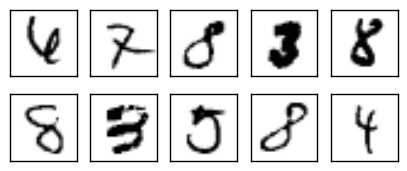

In [8]:
# Description : Function for P5
def P5():

### STUDENT START ###

    # Predict labels for the development data set by fitting a 1-NN model 
    # with the training data set
    pred_labels = predict_digits_kNN_single_k(train_data, train_labels, dev_data, dev_labels, 1)

    print 'Accuracy: %3.2f\n' % calc_accuracy(dev_labels, pred_labels)    
    print 'Confusion Matrix: '
    print(confusion_matrix(dev_labels, pred_labels, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
 
    # Create a new list with the difference between the dev labels and the 
    # predicted labels, in which only the mistakes will be non-zero
    pred_diff = dev_labels - pred_labels
    
    # Get the indices of the dev_data for which the 1-NN model made a mistake
    mistake_indices = [i for i, label in enumerate(pred_diff) if label <> 0]
    
    # Display the first 10 prediction mistakes as examples
    
    # Set dimensions of the grid of subplots
    grid, rows = plt.subplots(nrows = 2, 
                              ncols = 5,
                              figsize = (5, 2))
    
    # Remove ticks and labels of the 2 x 5 grid
    for ax in grid.axes:
        ax.set_xticks([])
        ax.set_yticks([])

    # Display the actual and predicted labels of the 10 
    # example prediction mistakes
    print '\n10 Example Mistakes:\n'
    for i in range(10):
        print 'Example %d: Actual Label = %d, Predicted Label = %d' % (i, dev_labels[mistake_indices[i]], pred_labels[mistake_indices[i]])
    
    # Index to keep track of the indices of the dev data set for 
    # which the 1-NN model made a mistake
    k = 0
    for i, row in enumerate(rows):
        for j, cell in enumerate(row):
            # Reshape the 1D feature vector for a single digit into 
            # a 2D matrix for rendering
            digit_matrix = np.reshape(dev_data[mistake_indices[k]], (digit_matrix_dim, digit_matrix_dim))
            # Show the digit in black and white color map
            cell.imshow(digit_matrix, cmap='Greys')
            k+=1
    
### STUDENT END ###

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.
Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:

•	preprocess the training data but not the dev data

•	preprocess the dev data but not the training data

•	preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.


Case 1: preprocess the training data but not the dev data
Accuracy: 0.61
Confusion Matrix: 
[[ 69   4   1   0   0  15   5   3   0   2]
 [  0 103   0   0   1   0   1   0   0   0]
 [  4  29  22   2   5  14  11  14   0   1]
 [  0  18   0  23   3  33   3   2   1   3]
 [  0  17   0   0  76   3   1   3   0   4]
 [  1  17   0   4   0  65   3   0   0   1]
 [  0   3   0   0   4   7  84   0   0   0]
 [  0  19   0   0   0   5   0  74   0  15]
 [  2  31   0   3  13  11   3   4  29   0]
 [  0  17   0   0  13   2   0   8   0  66]]

Case 2: preprocess the dev data but not the training data
Accuracy: 0.93
Confusion Matrix: 
[[ 99   0   0   0   0   0   0   0   0   0]
 [  0 103   0   0   1   0   1   0   0   0]
 [  2   0  94   1   0   0   0   1   4   0]
 [  1   0   0  77   0   0   0   2   5   1]
 [  1   0   1   0  90   0   2   0   3   7]
 [  1   0   0   4   0  78   2   0   6   0]
 [  2   1   0   0   1   0  93   0   1   0]
 [  1   0   3   0   0   0   0 102   2   5]
 [  1   1   0   0   0   1   0   0  93  

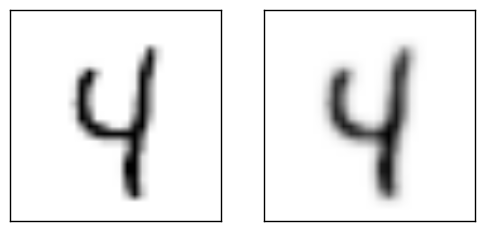

In [9]:
# Description: Function to apply Gaussian filter on a single 28 x 28 pixel 
#              matrix of a certain digit.  It loops through each pixel in 
#              the 28 x 28 matrix, sums up the neighboring pixels (up to 8) 
#              and the current pixel, and finally divide the sum with a 
#              certain number.  This number is determined by the number of 
#              digits being summed up (which could be less than 9 for the 
#              bordering cases) and a constant being passed in, which is 
#              expected to be <= 1 for good blurring effect.
# Parameters :
# m          : input pixel matrix
# constant   : base constant to be multipled by the number of cells in the 
#              neighborhood grid, which is usually 9 except the bordering cases
def gaussian_filter_matrix(m, constant):
    
    m_new = np.matrix.copy(m)
    
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            # Get start and end indices of the sub-matrix to sum up 
            # to avoid going out of bounds
            i_start = max(0, i - 1)
            i_end = min(digit_matrix_dim + 1, i + 2)
            j_start = max(0, j - 1)
            j_end = min(digit_matrix_dim + 1, j + 2)
            
            # Get size of the sub-matrix with the current pixel and 
            # its neighboring pixels
            m_size = m[i_start:i_end, j_start:j_end].shape[0] * m[i_start:i_end, j_start:j_end].shape[1]
            
            # Calculate the new, blurred pixel based on the sub-matrix, 
            # size of the sub-matrix and the passed in constant
            m_new[i, j] = np.sum(m[i_start:i_end, j_start:j_end]) / (constant * m_size) + m[i, j]
            
    return m_new

# Description: Function to apply Gaussian filter on a data set with multiple 
#              28 x 28 pixel matrices representing digits
# Parameters :
# data       : input data set with 28 x 28 pixel matrices
# constant   : base constant to be multipled by the number of cells in the 
#              neighborhood grid, which is usually 9 except the bordering cases
def gaussian_filter_data(data, constant):
    
    data_new = []
    
    for i in range(len(data)):
        # Reshape the 1D feature vector for a single digit into 
        # a 2D matrix for application of the Gaussian filter
        m = np.reshape(data[i], (digit_matrix_dim, digit_matrix_dim))
        # Apply Gaussian filter to each of the 28 x 28 pixel matrices in
        # the passed in data set
        m_new = gaussian_filter_matrix(m, constant)
        # Append the flattened version of the blurred pixel matrix
        # to the list to be returned
        data_new.append(m_new.flatten())
        
    return data_new

# Description : Function for P6
def P6():
    
### STUDENT START ###
    
    # Calling gaussian_filter_data on the dev data set 
    dev_data_gaussian = gaussian_filter_data(dev_data, 0.5)
    # Calling gaussian_filter_data on the training data set 
    train_data_gaussian = gaussian_filter_data(train_data, 0.5)
    
    # Case 1: preprocess the training data but not the dev data
    print '\nCase 1: preprocess the training data but not the dev data'    
    pred_labels = predict_digits_kNN_single_k(train_data_gaussian, train_labels, dev_data, dev_labels, 1)
    print 'Accuracy: %3.2f' % calc_accuracy(dev_labels, pred_labels)
    print 'Confusion Matrix: '
    print(confusion_matrix(dev_labels, pred_labels, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
    
    # Case 2: preprocess the dev data but not the training data
    print '\nCase 2: preprocess the dev data but not the training data'    
    pred_labels = predict_digits_kNN_single_k(train_data, train_labels, dev_data_gaussian, dev_labels, 1)
    print 'Accuracy: %3.2f' % calc_accuracy(dev_labels, pred_labels)
    print 'Confusion Matrix: '
    print(confusion_matrix(dev_labels, pred_labels, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

    # Case 3: preprocess both training and dev data
    print '\nCase 3: preprocess both training and dev data'    
    pred_labels = predict_digits_kNN_single_k(train_data_gaussian, train_labels, dev_data_gaussian, dev_labels, 1)
    print 'Accuracy: %3.2f' % calc_accuracy(dev_labels, pred_labels)
    print 'Confusion Matrix: '
    print(confusion_matrix(dev_labels, pred_labels, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
    
    # As a demonstration, show the first digit image in the dev data set in both its original form 
    # and the Gaussian blurred form
    print '\nFirst Digit in the dev data set (left: original, right: blurred):'
    p = plt.subplot(1, 2, 1)
    p.axes.set_xticks([])
    p.axes.set_yticks([])
    # Show the digit in black and white color map
    p.imshow(np.reshape(dev_data[0], (digit_matrix_dim, digit_matrix_dim)), cmap='Greys')
    
    p = plt.subplot(1, 2, 2)
    p.axes.set_xticks([])
    p.axes.set_yticks([])
    # Show the digit in black and white color map
    p.imshow(np.reshape(dev_data_gaussian[0], (digit_matrix_dim, digit_matrix_dim)), cmap='Greys')        
    
### STUDENT END ###

P6()

ANSWER: The blurring filter cases actually didn't do better than the base case where the 1-NN model was trained with the raw training data set.  Case 3 (preprocess both training and dev data) performed the best but it only tied with the base case (no blurring).

Using Training Data Set:

Accuracy of Base Case: 0.98

Accuracy of Case 1: preprocess the training data but not the dev data: 0.61

Accuracy of Case 2: preprocess the dev data but not the training data: 0.93

Accuracy of Case 3: preprocess both training and dev data: 0.98

I also tried running P5 and P6 using the mini training data set and one of the blurring filter cases did slighly better than the base case.  Compared to the accuracy of the base case using the original training data (0.89), case 3 (preprocess both training and dev data) did slightly better with an accuracy of 0.90.

Using Mini Training Data Set:

Accuracy of Base Case: 0.89

Accuracy of Case 1: preprocess the training data but not the dev data: 0.25

Accuracy of Case 2: preprocess the dev data but not the training data: 0.83

Accuracy of Case 3: preprocess both training and dev data: 0.90

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [10]:
# Description: Map a single raw pixel value to either binary (0, 1) 
#              or multinomial (0, 1, 2) values
# Parameters :
# pixel      : Raw pixel to be mapped
# cat_id     : ID specifying the categorization to be performed.  
#              There are 2 categorization systems for binary and 
#              multinomial (for testing purposes)
def map_pixel(pixel, cat_id):
    
    mapped_pixel = -1
    
    # cat_id = 4: <=0: 0; >0 and <1: 1; >=1: 2            
    if cat_id == 4:
        if pixel <= 0:
            mapped_pixel = 0
        elif pixel < 1:
            mapped_pixel = 1
        else:
            mapped_pixel = 2
    # cat_id = 3: <=0.33: 0; >0.33 and <=0.66: 1; >0.66: 2                     
    elif cat_id == 3:
        if pixel <= 0.33:
            mapped_pixel = 0
        elif pixel <= 0.66:
            mapped_pixel = 1
        else:
            mapped_pixel = 2
    # cat_id = 2: <=0: 0; >0: 1        
    elif cat_id == 2:
        if pixel <= 0:
            mapped_pixel = 0
        else:
            mapped_pixel = 1
    # cat_id = 1: <=0.5: 0; >0.5: 1
    else:
        if pixel <= 0.5:
            mapped_pixel = 0
        else:
            mapped_pixel = 1
            
    return mapped_pixel

# Description: Map a 28 x 28 pixel matrix to either binary (0, 1) 
#              or multinomial (0, 1, 2) values
# Parameters : 
# pixels     : Raw pixel matrix to be mapped
# cat_id     : ID specifying the categorization to be performed.  
#              There are 2 categorization systems for binary and 
#              multinomial (for testing purposes)
def map_pixels(pixels, cat_id):
    
    pixels_new = []

    for i in range(len(pixels)):
        pixels_new.append(map_pixel(pixels[i], cat_id))
            
    return pixels_new

# Description: Map all 28 x 28 pixel matrices in a data set to 
#              either binary (0, 1) or multinomial (0, 1, 2) values
# Parameters :
# data       : Data set with a list of 28 x 28 pixel matrices
# cat_id     : ID specifying the categorization to be performed.  
#              There are 2 categorization systems for binary and 
#              multinomial (for testing purposes)
def map_data(data, cat_id):
    
    data_new = []

    for i in range(len(data)):
        data_new.append(map_pixels(data[i], cat_id))
            
    return data_new

# Description : Function for P7
def P7():

### STUDENT START ###

    # BernoulliNB Case 1: <=0.5: 0; >0.5: 1                    
    train_data_binary = map_data(mini_train_data, 1)

    # Keep alpha as 1 and binarize as 0 since input data has already been pre-processed
    ber = BernoulliNB()
    ber.fit(train_data_binary, mini_train_labels)

    print 'BernoulliNB Case 1: <=0.5: 0; >0.5: 1\n'
    print 'Score: %3.2f' % ber.score(dev_data, dev_labels)
    pred_labels = ber.predict(dev_data)
    print 'Accuracy: %3.2f' % calc_accuracy(dev_labels, pred_labels)

    # BernoulliNB Case 2: <=0: 0; >0: 1                    
    train_data_binary = map_data(mini_train_data, 2)

    # Keep alpha as 1 and binarize as 0 since input data has already been pre-processed
    ber = BernoulliNB()
    ber.fit(train_data_binary, mini_train_labels)

    print '\nBernoulliNB Case 2: <=0: 0; >0: 1\n'
    print 'Score: %3.2f' % ber.score(dev_data, dev_labels)
    # Predict labels (digits) for development data set
    pred_labels = ber.predict(dev_data)
    print 'Accuracy: %3.2f' % calc_accuracy(dev_labels, pred_labels)
                                                
    # MultinomialNB Case 1: <=0.33: 0; >0.33 and <=0.66: 1; >0.66: 2
    train_data_multi = map_data(mini_train_data, 3)    
    mul = MultinomialNB()
    mul.fit(train_data_multi, mini_train_labels)

    print '\nMultinomialNB Case 1: <=0.33: 0; >0.33 and <=0.66: 1; >0.66: 2\n'    
    print 'Score: %3.2f' % mul.score(dev_data, dev_labels)
    # Predict labels (digits) for development data set
    pred_labels = mul.predict(dev_data)
    print 'Accuracy: %3.2f' % calc_accuracy(dev_labels, pred_labels)

    # MultinomialNB Case 2:<=0: 0; >0 and <1: 1; >=1: 2
    train_data_multi = map_data(mini_train_data, 4)    
    mul = MultinomialNB()
    mul.fit(train_data_multi, mini_train_labels)

    print '\nMultinomialNB Case 2: <=0: 0; >0 and <1: 1; >=1: 2\n'    
    print 'Score: %3.2f' % mul.score(dev_data, dev_labels)
    # Predict labels (digits) for development data set
    pred_labels = mul.predict(dev_data)
    print 'Accuracy: %3.2f' % calc_accuracy(dev_labels, pred_labels)
                        
### STUDENT END ###

P7()

BernoulliNB Case 1: <=0.5: 0; >0.5: 1

Score: 0.80
Accuracy: 0.80

BernoulliNB Case 2: <=0: 0; >0: 1

Score: 0.81
Accuracy: 0.81

MultinomialNB Case 1: <=0.33: 0; >0.33 and <=0.66: 1; >0.66: 2

Score: 0.80
Accuracy: 0.80

MultinomialNB Case 2: <=0: 0; >0 and <1: 1; >=1: 2

Score: 0.79
Accuracy: 0.79


ANSWER: I tried using two different categorization systems each to map the training set into binary values (0, 1) for the Bernoulli Naive Bayes model and also into multinomial values (0, 1, 2) for the Multinomial Naiave Bayes model.  The accuracy results are all very close, but the best BernoulliNB model (i.e., BernoulliNB Case 2, for which grayish pixels were categorized as black) is slightly more accurate than the best MultinomialNB (i.e., MultinomialNB Case 1, for which all pixel values between 0 and 1 were split 3 ways evenly between white, gray and black).  

I think this is due to the fact that the additional introduction of gray pixels which might have enhanced information around the edges and curves didn't really provide more predictive power to correctly differentiate among the 10 digits.  In other words, the very straight-forward approach of identifying any grayish pixels to be black was suffice to achieve relatively satisfactory accuracy.  Any more information than that used to train the model would likely lead to overfitting.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

•	Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [11]:
# Description : Function for P8
# Parameters  : 
# alphas      : Laplace smoothing parameter
def P8(alphas):

### STUDENT START ###

    # Perform a search for best score over values of alpha
    # for the BernoulliNB model
    gs = GridSearchCV(estimator = BernoulliNB(), param_grid = alphas)
    
    # Use BernoulliNB Case 2 mapping from P7 to obtain
    # mapped pixel data for fitting the BernoulliNB model
    train_data_binary = map_data(mini_train_data, 2)    
    gs.fit(train_data_binary, mini_train_labels)
    
    return gs

### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

nb = P8(alphas)

print 'Results from GridSearchCV on estimator BernoulliNB:\n'
print 'Best alpha: ', nb.best_params_
print 'Best score: ', nb.best_score_ 

for i in range(len(nb.grid_scores_)): 
    print nb.grid_scores_[i]

C:\Users\Vincent Chu\Anaconda2\lib\site-packages\sklearn\naive_bayes.py:766: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)
C:\Users\Vincent Chu\Anaconda2\lib\site-packages\sklearn\naive_bayes.py:785: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))


Results from GridSearchCV on estimator BernoulliNB:

Best alpha:  {'alpha': 0.1}
Best score:  0.821
mean: 0.09200, std: 0.00080, params: {'alpha': 0.0}
mean: 0.82000, std: 0.02208, params: {'alpha': 0.0001}
mean: 0.82000, std: 0.02305, params: {'alpha': 0.001}
mean: 0.82000, std: 0.02607, params: {'alpha': 0.01}
mean: 0.82100, std: 0.02454, params: {'alpha': 0.1}
mean: 0.81900, std: 0.02147, params: {'alpha': 0.5}
mean: 0.81200, std: 0.01814, params: {'alpha': 1.0}
mean: 0.81000, std: 0.01767, params: {'alpha': 2.0}
mean: 0.77500, std: 0.01719, params: {'alpha': 10.0}


ANSWER: The best value for alpha is 0.01 with a mean score of 0.821.  The score for alpha = 0 is only 0.092 and is significantly lower than other values of alpha.  This is expected as alpha = 0 means there was no Laplace smoothing applied on the BernoulliNB estimator.  The use of Laplace smoothing helped counteract the effect of overfitting on the training data.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.
Hint: examine the parameters estimated by the fit() method, theta_ and sigma_.

In [12]:
# Description : Function for P9
def P9():

### STUDENT START ###

    # Create a GaussianNB estimator object
    gau = GaussianNB()

    # Fit the GaussianNB model with the training data as is
    print 'Fitting GaussianNB model with train data:\n'
    gau.fit(mini_train_data, mini_train_labels)
    print 'Accuracy: %3.2f' % gau.score(dev_data, dev_labels)
    print 'Sigma: ', gau.sigma_ 
    print 'Theta: ', gau.theta_ 
            
    # Fit the GaussianNB model with the training data as is
    # but forcing the sigma values (variances) of the model to be 
    # a relatively bigger constant than the estimated values
    print '\nFitting GaussianNB model after setting sigma = 3:\n'
    gau.sigma_ = gau.sigma_ * 0.0 + 3.0
    print 'Accuracy: %3.2f' % gau.score(dev_data, dev_labels)
    print 'Sigma: ', gau.sigma_ 
    print 'Theta: ', gau.theta_ 
        
    return gau

### STUDENT END ###

gnb = P9()

Fitting GaussianNB model with train data:

Accuracy: 0.62
Sigma:  [[  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 ..., 
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]]
Theta:  [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]

Fitting GaussianNB model after setting sigma 

ANSWER: Examining the sigma values of the original GaussianNB, they are extremely small since most of the pixels are almost always off (0) in the training data.  The probablity for these pixels to be on (1) is basically 0 and that causes the probability P(x|Y) to be zero since it is the multiplication of the individual P(xi|Y).

The solution is to increase sigma to some significant value.  After failing to have any effect by multiplying the sigma values by a constant, I tried just setting sigma to a constant value that is much higher than the previous sigma values.  This improved accuracy of the GaussianNB model from 0.62 to 0.80, which is closer to the 0.821 best accuracy returned by GridSearchCV on estimator BernoulliNB.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

•	You can use np.random.rand() to generate random numbers from a uniform distribution

•	The estimated probability of each pixel is stored in feature_log_prob_. You'll need to use np.exp() to convert a log probability back to a probability.

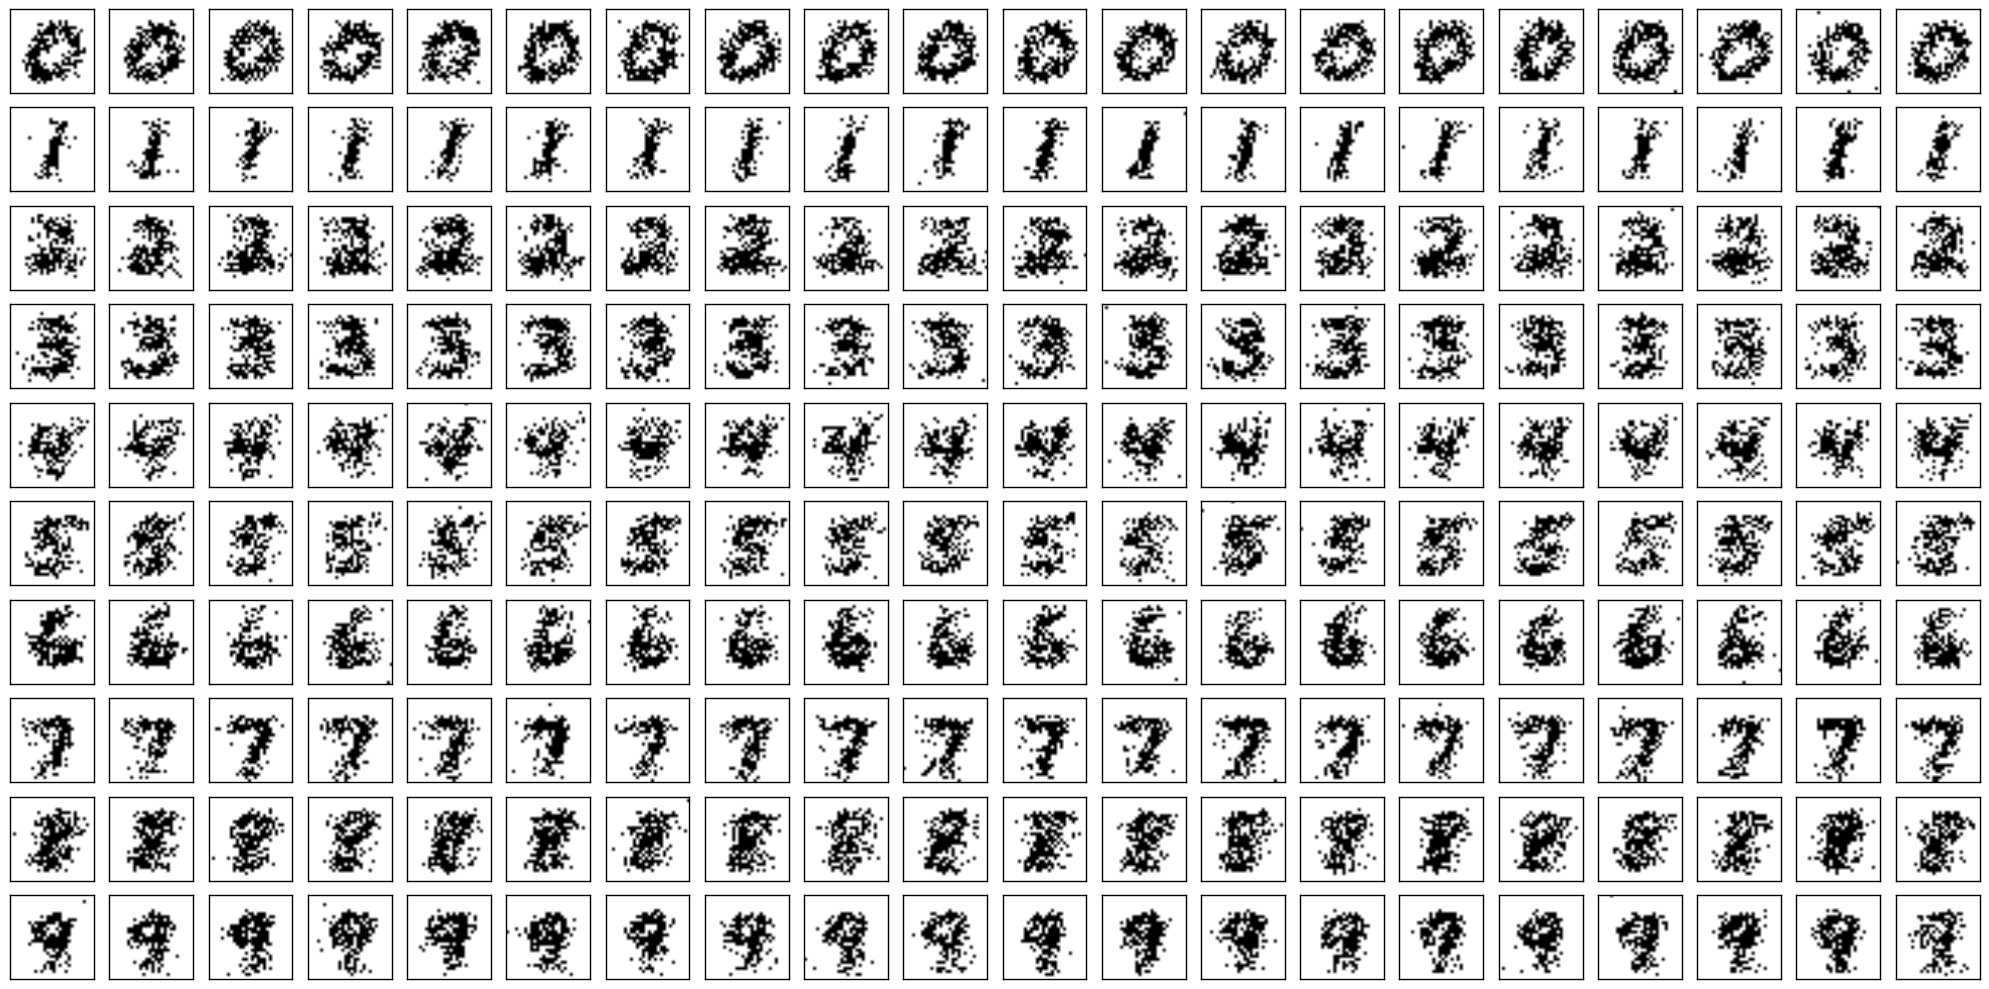

In [13]:
# Description: Generate the value of a single pixel based on its probability 
#              estimated by BernoulliNB and a randomly generated number from 
#              a uniform distribution over [0, 1)
# Parameters :
# prob       : probability of the pixel
# rand_num   : randomly generated floating point number over [0, 1)
# black_digit: black digit with white background to be rendered if 1, 
#              white digit with black background otherwise  
def gen_pixel(prob, rand_num, black_digit):
    
    pixel = 0
    
    # If the digit is to be rendered in black with white background
    if black_digit == 1:
        # Set pixel to be 1 if the estimated probability is larger
        # than or equal to the random number
        if prob >= rand_num:
            pixel = 1
    # If the digit is to be rendered in white with black background            
    else:
        # Set pixel to be 1 if the estimated probability is smaller
        # than or equal to the random number        
        if prob <= rand_num:
            pixel = 1
    
    return pixel  
             
# Description : Function for P10
# Parameters  :
# num_examples: Number of examples to display for each digit
def P10(num_examples):

### STUDENT START ###

    # Use BernoulliNB Case 2 (<=0: 0; >0: 1) from P7                    
    train_data_binary = map_data(mini_train_data, 2)

    # Set alpha as 0.1, which has the best score according to P8
    ber = BernoulliNB(alpha = 0.1)
    ber.fit(train_data_binary, mini_train_labels)

    # Get the estimated probability of each pixel for each of the 
    # 10 classes (i.e., 10 digits)
    digit_probs = np.exp(ber.feature_log_prob_)

    # Set dimensions of the grid of subplots
    grid, rows = plt.subplots(nrows = 10, 
                              ncols = num_examples,
                              figsize = (num_examples, 10))

    # Remove ticks and labels of the 10 x num_examples grid
    for ax in grid.axes:
        ax.set_xticks([])
        ax.set_yticks([])

    # Iterate through each of the 10 digits and generate pixel 
    # matrices of each digit using the BernoulliNB generative model
    for i, row in enumerate(rows):
        for j, cell in enumerate(row):
            digit_matrix = []
            for k in range(len(digit_probs[i])):
                # Generate the value of a single pixel based on its probability 
                # estimated by BernoulliNB, and add to the current digit pixel 
                # matrix
                digit_matrix.append(gen_pixel(digit_probs[i, k], np.random.rand(), 1))
            # Show the digit generated by BernoulliNB in black and white color map
            cell.imshow(np.reshape(digit_matrix, (digit_matrix_dim, digit_matrix_dim)), cmap='Greys')

    plt.tight_layout()    
        
### STUDENT END ###

P10(20)

ANSWER: The generated digits are less recognizable than the training data because it seems to have more ramdom noises (i.e., random black pixels) kind of far away from the main cluters of black pixels making up the digit.  This is kind of expected as this is the result of a generative model based on probability and not exactly what each digit looked like in the training data.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [14]:
# Description : Function for P11
# Parameters  :
# buckets     : posterior buckets
# correct     : correct counters by posterior bucket
# total       : total counters by posterior bucket
def P11(buckets, correct, total):
    
### STUDENT START ###

    # Use BernoulliNB Case 2 (<=0: 0; >0: 1) from P7                    
    train_data_binary = map_data(mini_train_data, 2)

    # Set alpha as 0.1, which has the best score according to P8
    ber = BernoulliNB(alpha = 0.1)
    ber.fit(train_data_binary, mini_train_labels)
    
    # Get predicted labels and estimated probabilities for the
    # dev data set
    pred_labels = ber.predict(dev_data)
    pred_probs = ber.predict_proba(dev_data) 
    
    # Determine the max posterior for each prediction of the
    # digits in the dev data set
    pred_max_posteriors = []
    for i in range(len(pred_probs)):
        pred_max_posteriors.append(max(pred_probs[i]))

    # Loop through each of the predictions of the dev data set
    # and determine number of members and members with correct 
    # predictions for each of the posterior buckets passed in
    for i in range(len(buckets)):
        for j in range(len(pred_max_posteriors)):
            if pred_max_posteriors[j] >= buckets[i]:
                total[i] += 1
                if pred_labels[j] == dev_labels[j]:
                    correct[i] += 1
        
### STUDENT END ###

# Added 0.8 to compare its result with that of 0.9
buckets = [0.5, 0.8, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    # Added the multiplication of 1.0m otherwise the integer division 
    # correct[i] / total[i] would always return 0
    if (total[i] > 0): accuracy = correct[i] * 1.0 / total[i]
    print 'p(pred) <= %.13f    total = %3d    correct = %d    accuracy = %.3f' % (buckets[i], total[i], correct[i], accuracy)

p(pred) <= 0.5000000000000    total = 998    correct = 816    accuracy = 0.818
p(pred) <= 0.8000000000000    total = 980    correct = 810    accuracy = 0.827
p(pred) <= 0.9000000000000    total = 967    correct = 804    accuracy = 0.831
p(pred) <= 0.9990000000000    total = 896    correct = 769    accuracy = 0.858
p(pred) <= 0.9999900000000    total = 843    correct = 746    accuracy = 0.885
p(pred) <= 0.9999999000000    total = 779    correct = 707    accuracy = 0.908
p(pred) <= 0.9999999990000    total = 733    correct = 682    accuracy = 0.930
p(pred) <= 0.9999999999900    total = 681    correct = 640    accuracy = 0.940
p(pred) <= 0.9999999999999    total = 632    correct = 601    accuracy = 0.951
p(pred) <= 1.0000000000000    total = 614    correct = 588    accuracy = 0.958


ANSWER: I would categorize our BernoulliNB model as weakly calibrated as the accuracy for the posterior bucket 0.90 is less than 90% (only 83.1%).  The accuracy actually increases as the posterior of the predicted class increases from 0.50 to 0.80 to 0.90 and so on, so this BernoulliNB classifier is weakly calibrated but not poorly calibrated since there is indeed an apparent  positive correlation between the posterior and the accuracy.

(12) EXTRA CREDIT
Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
•	Try summing the pixel values in each row and each column.
•	Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.
Make sure you comment your code well!

In [15]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()